# Introduction to Text Classification

-----

In this notebook, we introduce text classification. This is a powerful, yet sometimes intimidating topic that finds applications in a number of different areas: product reviews, sentiment analysis, and document classification. Part of the challenge lies in the difficulty of applying mathematical algorithms to (potentially very large) character data sets. In Python, however, this challenge is considerably simplified by using the NLTK and the scikit-learn machine learning libraries. We first introduce a new classification algorithm, Naive Bayes Classifier. We then introduce how to use Naive Bayes Classifier and other classification algorithms to do document classification on the twenty newsgroup dataset.

-----

## Table of Contents

[Data](#Data)

[Naive Bayes Classifier](#Naive-Bayes-Classifier)

[Document Classification](#Document-Classification)

- [Naive Bayes Classifier](#Naive-Bayes-Classifier)
 - [Use CountVectorizer](#Use-CountVectorizer)
 - [Use TF-IDF](#Use-TF-IDF)
- [Linear SVC](#Linear-SVC)
- [Logistic Regression](#Logistic-Regression)

-----

Before proceeding with the rest of this notebook, we first include our standard notebook setup code and we define our _data_ directory.

-----

In [1]:
# Set up notebook

%matplotlib inline

# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

-----

[[Back to TOC]](#Table-of-Contents)


## Data

To get started with text classification, we will analyze the [twenty newsgroup][tng] data set. We first download this data. Scikit-learn has built in methods for doing this. The data are made available via a custom object, but we can access the data of interest by using dictionary keys. Before delving into text classification, we first explore this data over several Code cells to understand more about the task at hand.

In case you are unaware, one primary use of the early Internet was to share information among interested groups via newsgroups or bulletin boards. Users could subscribe to these groups to send and receive postings of interest. This text classification problem uses postings to twenty newsgroups. The individual newsgroup is the classification target and the text in the postings are used to create the features. These postings were similar to emails, thus each posting will have a header, the article body, which might quote all or part of a previous message, and possibly a footer (like an email signature). While we use the entire posting in these notebooks, you can have the header, quoted text, and the footer removed by scikit-learn by including the remove attribute, indicating whether these sections should be removed. This attribute can take one or all of the values: header, footer, and quotes. For example, the following attribute would be used to remove both headers and footers.

```remove =('headers', 'footers')```

In the next Code cell, we first load the training and testing text set from sickit learn datasets as `sklearn.utils.Bunch` objects. The `Bunch` object works similarly to a dictionary. We print out the keys in the training object for further exploration. The testing object has exact the same structure as the training object.

-----

[tng]: http://kdd.ics.uci.edu/databases/20newsgroups/20newsgroups.data.html

In [2]:
# load dataset
from sklearn.datasets import fetch_20newsgroups

# To learn more about these data, either browse the relevant 
# scikit-learn documentation, or enter help(fetch_20newsgroups) in a Code cell

# Get training text set
train = fetch_20newsgroups(data_home='.', subset='train')
# Get testing text set
test = fetch_20newsgroups(data_home='.', subset='test')
print(train.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


---

There are 5 keys in the `train` object:
- data: List of text messages
- filenames: List of file names, for each message in data, there's a corresponding file name. This is normally not needed in classification.
- target: Numeric code for the 20 news groups, from 0 to 19. Each message has a corresponding target, that is used as label or class in classification. 
- target_names: String, name of the 20 targets.
- DESCR: Description of the dataset.

If you want to learn more details about the 20 news groups dataset, you can print out the description by running the following code in a Code cell:
`print(train['DESCR'])`

In the next Code cell, we explore the training and testing dataset a bit. There are 11314 training text message and 7532 testing messages. We'll also print out the 20 classes and their names.

In [3]:
# Exploratory Data Analysis
print(f"Number of Training Samples: {len(train['data'])}")
print(f"Number of Testing Samples: {len(test['data'])}")
print(40*'-')

for idx, label in enumerate(train['target_names']):
    print(f'Class {idx:2d} = {label}')

Number of Training Samples: 11314
Number of Testing Samples: 7532
----------------------------------------
Class  0 = alt.atheism
Class  1 = comp.graphics
Class  2 = comp.os.ms-windows.misc
Class  3 = comp.sys.ibm.pc.hardware
Class  4 = comp.sys.mac.hardware
Class  5 = comp.windows.x
Class  6 = misc.forsale
Class  7 = rec.autos
Class  8 = rec.motorcycles
Class  9 = rec.sport.baseball
Class 10 = rec.sport.hockey
Class 11 = sci.crypt
Class 12 = sci.electronics
Class 13 = sci.med
Class 14 = sci.space
Class 15 = soc.religion.christian
Class 16 = talk.politics.guns
Class 17 = talk.politics.mideast
Class 18 = talk.politics.misc
Class 19 = talk.religion.misc


---
Now let's take a look at a random message in the training text set. We'll print out the message body and its target and target name.

In [4]:
# Pick a single article and display information
item_number = 250
class_num = train['target'][item_number]
print(f'Class Number = {class_num}')
print(f'Class Name = {train["target_names"][class_num]}')
print("-"*80)
print(train['data'][item_number])

Class Number = 18
Class Name = talk.politics.misc
--------------------------------------------------------------------------------
From: gemmellj@merrimack.edu
Subject: e-mail to the hill ??
Organization: Merrimack College, No. Andover, MA, USA
Lines: 4

Now, that Clinton can get e-mail, i'm wondering if Congress is also
going on line.. If so, does anyone have the address to reach them??
I'm also looking for Bill's e-mail address.
please e-mail me, i am not a regualar reader of this newsgrouop.



-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cell, we print out a random message in the training text set. In the following Code cell, try to print out a random message and its target name from the testing text set.


-----

[[Back to TOC]](#Table-of-Contents)

## Naive Bayes Classifier

One of the simplest techniques for performing text classification is the [Naive Bayes Classifier][nbd]. This technique is popular, in part because of its simplicity, yet it also provides a quick technique that can provide reasonable results. Fundamentally this method applies Bayes Theorem by (naively) assuming independence between the features. 

### Bayes Theorem
Bayes Theorem describes the probability of an event, based on prior knowledge of conditions that might be related to the event. 

Bayes theorem is stated mathematically as the following equation:

$$
\textrm{P(A|B)} = \frac{\textrm{P(B|A)} \textrm{P(A)}}{\textrm{P(B)}}
$$

Where A and B are events.
- P(A) is the probability of observing event A.
- P(B) is the probability of observing event B.
- P(A | B) is a conditional probability: the likelihood of event A occurring given that B is true.
- P(B | A) is a conditional probability: the likelihood of event B occurring given that A is true.

With P(A), P(B) and P(B|A) available, we can calculate P(A|B) with this equation.

### Bayes Theorem Example
Let's use a screening test for a particular cancer as example to understand Bayes Theorem.

Assume we have a dataset of the cancer screening test results for 10,000 patients. 1% of patients actually have the cancer; If a patient has the cancer, there's 80% of chance that the test will be positive(true positive); If a patient doesn't have the cancer, the test still has 5% of chance to be positive(false positive). The question is, if a patient does test positive, what's the probability that this patient really has the cancer?

Let's crunch the numbers first.
- 1% of 10,000 patients have the cancer. That means 100 patients have the cancer and 9,900 don't.
- 80% cancer patients tested positive, so out of 100 patients that have cancer, 80 tested positive (true positive), 20 tested negative (false negative)
- 5% of the non-cancer patients tested positive, so out of 9,900 patients, 495 tested positive (false positive), and 9,405 tested negative (true negative)
- The accuracy of the test is $\frac{True Positive + True Negative}{Total Number}$ = $\frac{80+9405}{10000}$ = 95%
- Percentage of all who test positive that really have cancer is $\frac{True Positive}{All Positive}$ = $\frac{80}{80+495}$=14%

So, even though the cancer screening test has an accuracy rate of 95%, if a patient is tested positive, there's still only about 14% of chance that he/she really has the cancer. 

Now let's use Bayes Theorem to solve the problem.
- Event A is has the cancer, P(A) is the probability to have the cancer, which is 1%.
- Event B is test positive, P(B) is the probability to test positive for all patients, in this case, it's $\frac{80+495}{10000}$=5.75%.
- P(B|A) is the likelihood of testing positive when having the cancer, in this case, it's 80%.
- P(A|B) is the likelihood of having cancer when tested positive, which is the probability we are trying to find out.

From the Bayes Theorem equation, $\textrm{P(A|B)} = \frac{\textrm{P(B|A)} \textrm{P(A)}}{\textrm{P(B)}}$ = $\frac{0.8*0.01}{0.0575}$ = 14%.

### Bayes Theorem on Text Analysis

When we apply Bayes Theorem to text analysis, for example, to classify topic of a text:
- A represents a topic, P(A) is the percent of topic "A" among all messages.
- B represents occurrence of a word "B", P(B) is the frequency of the word "B" in the text.
- P(B|A) is the likely frequency of the word "B" appears in the text if the text belongs to the topic "A"

With Bayes Theorem, we can calculate P(A|B), or the likelihood that the text belongs to topic "A" if word "B" appears in the text for a give frequency. We can get P(A), P(B) and P(B|A) from the training data and calculate P(A|B). When we combine P(A|B) of all words(all different "B"s) in the text, we can get the overall probability of the text belonging to the topic "A".


[nbd]: https://en.wikipedia.org/wiki/Naive_Bayes_classifier


-----

[[Back to TOC]](#Table-of-Contents)

## Document Classification

Before introducing the first classification technique, let's examine one document that is in the test data set. In the next Code cell, we display a piece of message in the test set.

Reviewing this single posting, we notice several issues that might affect our classification process. First, if we remove the header, footer, and quoted text, some message will have little to no signal. For example, the message below would simply contain 'In a word, yes.'. Second, if we don't remove this information, our documents will include email address information (like com, edu, etc.), proper names, and information such as dates or monetary information. Finally, the content in some categories will clearly overlap, such as _alt.atheism_ and _soc.religion.christian_. 

In the end, these issues demonstrate the needs for manual intervention and introspection during the machine learning process. For the first issue, we will keep the header, footer and quoted text in the dataset. For the second, we expect TF-IDF would help. The frequency of terms in email address like 'com' should reduce their predicting weight due to TF-IDF; For the third issue, we again hope TF-IDF could help. For example, both "atheism" and "god" appears in the message, but "god" is likely to appear in both _alt.atheism_ and *soc.religion.christian*, while "atheism" is more likely to appear in _alt.atheism_. Thus we expect TF-IDF will give "atheism" more predicting power than "god" in classifying this message.

We will continually want to analyze classification results to ensure we understand what is occurring and why it is occurring.

-----


In [5]:
test_message = 2
class_num = test['target'][test_message]
print(f'Class Number = {class_num}')
print(f'Class Name = {test["target_names"][class_num]}')
print("-"*80)
print(test['data'][test_message])

Class Number = 0
Class Name = alt.atheism
--------------------------------------------------------------------------------
From: mathew <mathew@mantis.co.uk>
Subject: Re: STRONG & weak Atheism
Organization: Mantis Consultants, Cambridge. UK.
X-Newsreader: rusnews v1.02
Lines: 9

acooper@mac.cc.macalstr.edu (Turin Turambar, ME Department of Utter Misery) writes:
> Did that FAQ ever got modified to re-define strong atheists as not those who
> assert the nonexistence of God, but as those who assert that they BELIEVE in 
> the nonexistence of God?

In a word, yes.


mathew



-----

### Naive Bayes Classifier

We first try the [Naive Bayes classifier][nbd]. In scikit-learn, we will use a [Multinomial Naive Bayes][nbapi] model, where we treat each feature(token) independently. Thus we calculate the likelihood of a feature corresponding to each training label, and the accumulation of these likelihoods provides our overall classification. By working with log-likelihoods, this accumulation becomes a simple sum.

#### Use CountVectorizer

In the next Code cell, we first use `CountVectorizer` to create the _document term matrix_, set `stop_words='english'` to apply stop words filtering, then train the Multinomial Naive Bayes classifier and print out the accuracy score of the model.

[nbd]: https://en.wikipedia.org/wiki/Naive_Bayes_classifier
[nbapi]: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer

In [6]:
# Classify text with Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# Create DTM
cv = CountVectorizer(stop_words='english')
train_dtm = cv.fit_transform(train['data'])
test_dtm = cv.transform(test['data'])

# Create Classifier
nb = MultinomialNB()
nb = nb.fit(train_dtm, train['target'])

# Predict and display score
predicted = nb.predict(test_dtm)
scr = 100.0 * nb.score(test_dtm, test['target'])
print(f'NB prediction accuracy = {scr:5.1f}%')

NB prediction accuracy =  80.2%


-----

We can also use the built-in `metrics` methods to display more information about the classification results like the classification report shown in the next Code cell. Notice how most labels are predicted well, or at least close to the average. But some, such as _comp.os.ms-windows.misc_, are predicted poorly, suggesting improvements will be needed.

-----

In [7]:
from sklearn import metrics
print(metrics.classification_report(test['target'], 
                                    predicted,
                                    target_names = test['target_names']))

                          precision    recall  f1-score   support

             alt.atheism       0.80      0.81      0.80       319
           comp.graphics       0.65      0.80      0.72       389
 comp.os.ms-windows.misc       0.80      0.04      0.08       394
comp.sys.ibm.pc.hardware       0.55      0.80      0.65       392
   comp.sys.mac.hardware       0.85      0.79      0.82       385
          comp.windows.x       0.69      0.84      0.76       395
            misc.forsale       0.89      0.74      0.81       390
               rec.autos       0.89      0.92      0.91       396
         rec.motorcycles       0.95      0.94      0.95       398
      rec.sport.baseball       0.95      0.92      0.93       397
        rec.sport.hockey       0.92      0.97      0.94       399
               sci.crypt       0.80      0.96      0.87       396
         sci.electronics       0.79      0.70      0.74       393
                 sci.med       0.88      0.87      0.87       396
         

-----

We can also visually display the confusion matrix (where we show how documents were misclassified) by using Seaborn to create a _heatmap_ visual. We will use the `confusion` function which we introduced in previous lessons to plot the confusion matrix. First, we load the Python file that defines the function from the helper_code folder and subsequently use the `confusion` function to display the results from our Naive Bayes model.

-----

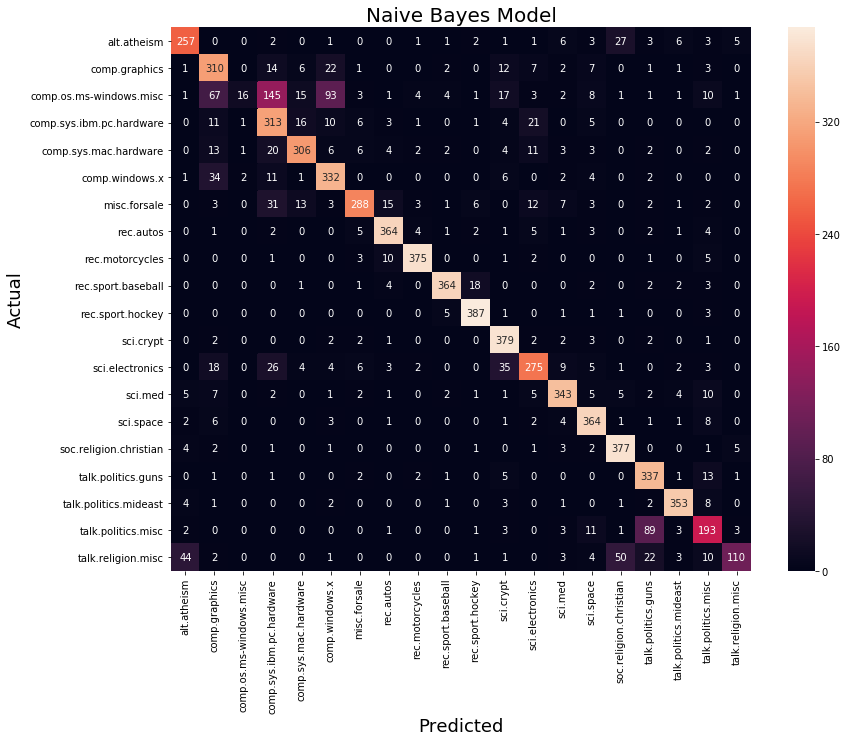

In [8]:
from helper_code import mlplots as ml

fig, ax = plt.subplots(figsize=(13, 10))
# Call confusion matrix plotting routine
ml.confusion(test['target'], predicted, test['target_names'], 'Naive Bayes Model')

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used `CountVectorizer` with `stop_words='english'` to create a document term matrix, and a Naive Bayes algorithm to classify new document by using this DTM. Now that you have run the notebook, go back and make the following changes to see how the results change.

1. Change the `CountVectorizer` to remove stop_words setting. Does this change the classification results?
2. Change the smoothing parameter $\alpha$ for the `MultinomialNB` classifier, from the default of one to zero and next some fractional value between zero and one. How does this change the classification results?(run `help(MultinomialNB)` for more detail about the arguments of the classifier)

-----

#### Use TF-IDF

In the next Code cell, we first use `TfidfVectorizer` to create the _document term matrix_, then train the Multinomial Naive Bayes classifier and print out the accuracy score of the model.

By applying TF-IDF, the accuracy score doesn't seem to improve a lot, but we get a big improvement in predicting _comp.os.ms-windows.misc_. This is demonstrated in both classification report and the confusion matrix. 

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create DTM
tf_cv = TfidfVectorizer(stop_words='english')
train_dtm_tf = tf_cv.fit_transform(train['data'])
test_dtm_tf = tf_cv.transform(test['data'])

nb = MultinomialNB()
nb = nb.fit(train_dtm_tf, train['target'])

predicted = nb.predict(test_dtm_tf)
scr = 100.0 * nb.score(test_dtm_tf, test['target'])
print(f'NB (TF-IDF with Stop Words) prediction accuracy = {scr:5.1f}%')

NB (TF-IDF with Stop Words) prediction accuracy =  81.7%


In [10]:
print(metrics.classification_report(test['target'], 
                                    predicted,
                                    target_names = test['target_names']))

                          precision    recall  f1-score   support

             alt.atheism       0.80      0.69      0.74       319
           comp.graphics       0.78      0.72      0.75       389
 comp.os.ms-windows.misc       0.79      0.72      0.75       394
comp.sys.ibm.pc.hardware       0.68      0.81      0.74       392
   comp.sys.mac.hardware       0.86      0.81      0.84       385
          comp.windows.x       0.87      0.78      0.82       395
            misc.forsale       0.87      0.80      0.83       390
               rec.autos       0.88      0.91      0.90       396
         rec.motorcycles       0.93      0.96      0.95       398
      rec.sport.baseball       0.91      0.92      0.92       397
        rec.sport.hockey       0.88      0.98      0.93       399
               sci.crypt       0.75      0.96      0.84       396
         sci.electronics       0.84      0.65      0.74       393
                 sci.med       0.92      0.79      0.85       396
         

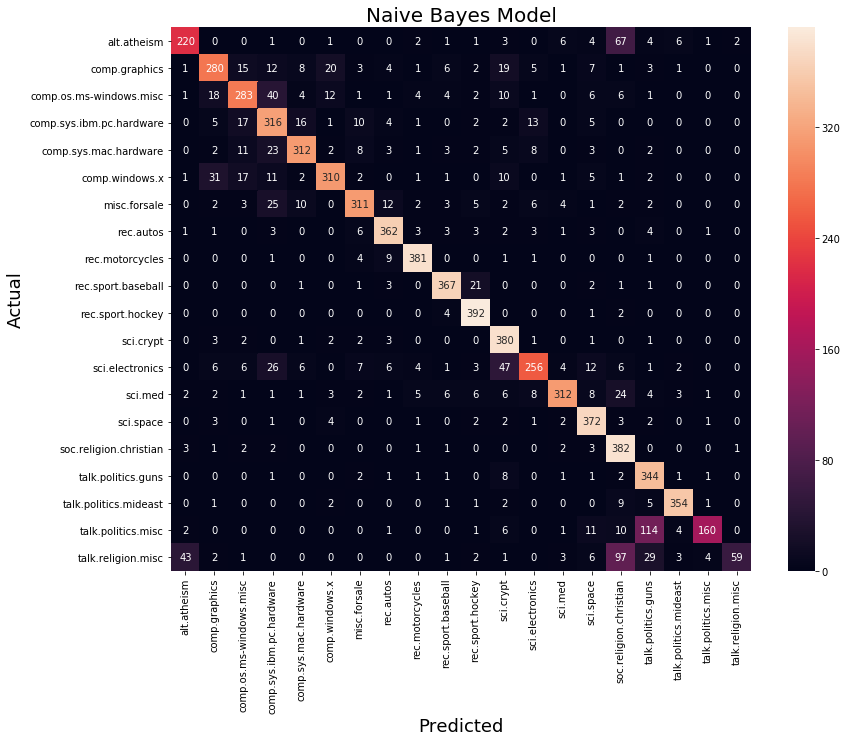

In [11]:
fig, ax = plt.subplots(figsize=(13, 10))
# Call confusion matrix plotting routine
ml.confusion(test['target'], predicted, test['target_names'], 'Naive Bayes Model')

-----

### Linear SVC

One of the simplest classification techniques to understand is [support vector machine][svmd] classification, or SVC. SVC attempts to divide data by finding (hyper-)planes that optimally differentiate data between classes. For our text data mining, we can employ linear SVM for classification, known as linear SVC, to classify text documents by their token feature vectors. The scikit_learn library implements this technique in the [`LinearSVC`][lsvc] class. 

In the next Code cell, we will use the train and test DTM created by `TfidfVectorizer` in above code to test the `LinearSVC`.

Notice how the output classes are predicted more consistently than our first classification attempt (i.e., the metrics are consistent across classes).

-----
[lsvc]: http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
[svmd]: https://en.wikipedia.org/wiki/Support_vector_machine

In [12]:
from sklearn.svm import LinearSVC

svc = LinearSVC(C=1000)

svc = svc.fit(train_dtm_tf, train['target'])
predicted = svc.predict(test_dtm_tf)

scr = 100.0 * svc.score(test_dtm_tf, test['target'])
print(f'SVC (TF-IDF with Stop Words) prediction accuracy = {scr:5.1f}%')

SVC (TF-IDF with Stop Words) prediction accuracy =  83.4%


In [13]:
print(metrics.classification_report(test['target'], 
                                    predicted,
                                    target_names = test['target_names']))

                          precision    recall  f1-score   support

             alt.atheism       0.85      0.76      0.80       319
           comp.graphics       0.76      0.78      0.77       389
 comp.os.ms-windows.misc       0.72      0.70      0.71       394
comp.sys.ibm.pc.hardware       0.66      0.72      0.69       392
   comp.sys.mac.hardware       0.81      0.83      0.82       385
          comp.windows.x       0.83      0.74      0.79       395
            misc.forsale       0.73      0.85      0.79       390
               rec.autos       0.90      0.88      0.89       396
         rec.motorcycles       0.95      0.95      0.95       398
      rec.sport.baseball       0.90      0.93      0.92       397
        rec.sport.hockey       0.96      0.97      0.97       399
               sci.crypt       0.93      0.93      0.93       396
         sci.electronics       0.76      0.75      0.76       393
                 sci.med       0.91      0.85      0.87       396
         

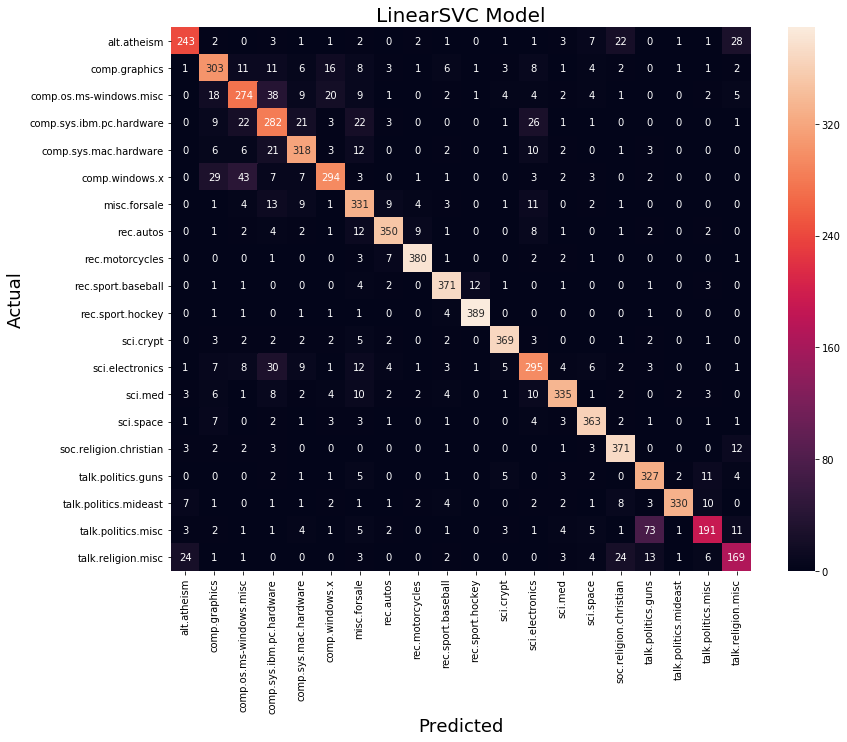

In [14]:
fig, ax = plt.subplots(figsize=(13, 10))
# Call confusion matrix plotting routine
ml.confusion(test['target'], predicted, test['target_names'], 'LinearSVC Model')

-----

### Logistic Regression

[Logistic Regression][lrd] is typically employed on categorical variables, such as yes/no decision, or win/loss likelihoods. In the case of many labels, we can use the trick that logistic regression can quantify the likelihood a vector is in or out of a particular category. Thus, by computing this over all categories we can determine the best label for each test vector. [scikit-learn][sllr] provides an implementation that can be easily used for our classification problem.

-----

[lrd]: https://en.wikipedia.org/wiki/Logistic_regression
[sllr]: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [15]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1000)

lr = lr.fit(train_dtm_tf, train['target'])
predicted = lr.predict(test_dtm_tf)

scr = 100.0 * lr.score(test_dtm_tf, test['target'])
print(f'LR (TF-IDF with Stop Words) prediction accuracy = {scr:5.1f}%')

LR (TF-IDF with Stop Words) prediction accuracy =  84.9%


In [16]:
print(metrics.classification_report(test['target'], 
                                    predicted,
                                    target_names = test['target_names']))

                          precision    recall  f1-score   support

             alt.atheism       0.83      0.79      0.81       319
           comp.graphics       0.75      0.81      0.78       389
 comp.os.ms-windows.misc       0.77      0.74      0.75       394
comp.sys.ibm.pc.hardware       0.69      0.74      0.72       392
   comp.sys.mac.hardware       0.81      0.85      0.83       385
          comp.windows.x       0.86      0.76      0.81       395
            misc.forsale       0.81      0.89      0.85       390
               rec.autos       0.91      0.90      0.91       396
         rec.motorcycles       0.96      0.96      0.96       398
      rec.sport.baseball       0.91      0.94      0.93       397
        rec.sport.hockey       0.96      0.97      0.97       399
               sci.crypt       0.94      0.93      0.94       396
         sci.electronics       0.78      0.79      0.79       393
                 sci.med       0.90      0.87      0.89       396
         

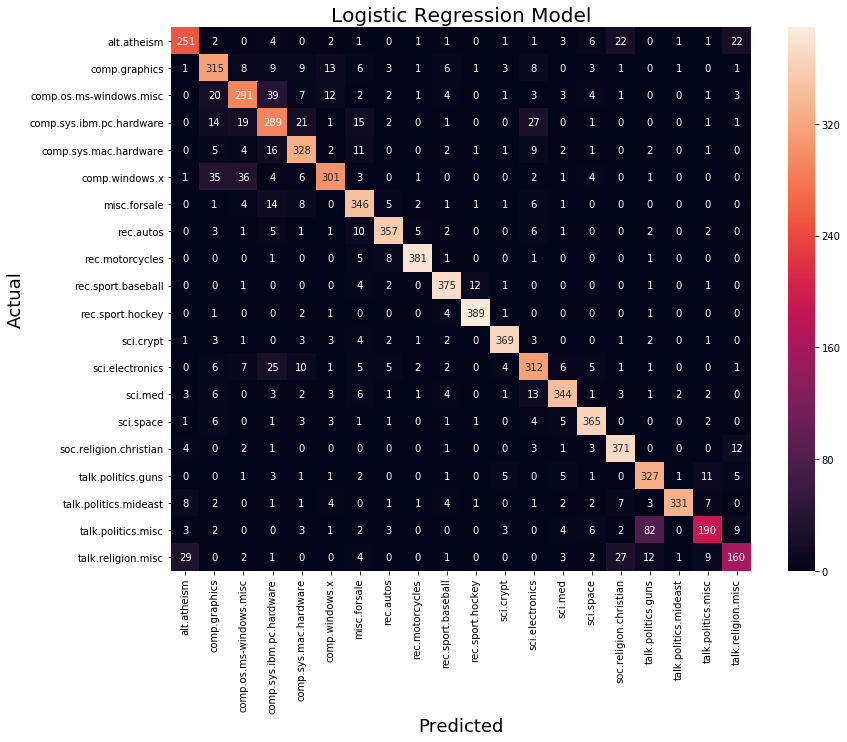

In [17]:
fig, ax = plt.subplots(figsize=(13, 10))
# Call confusion matrix plotting routine
ml.confusion(test['target'], predicted, test['target_names'], 'Logistic Regression Model')

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we introduced TF-IDF and demonstrated other, more powerful classification algorithms to this text classification problem. Now that you have run the notebook, go back and make the following changes to see how the results change.

1. Try changing the following parameters to `CountVectorizer` or `TfidfVectorizer`: `lowercase`, `max_features`, `min_df` and `max_df`, and `norm`. How do these attributes affect the performance of the classification?

2. When using `LogisticRegression`, we set inverse of regularization strength `C` to 1000. Try some other `C` values and run the classification. How does this change the results?

3. Add a (random)grid search to one particular classification algorithm; for example, `LogisticRegression` to find the optimal set of parameters to achieve the highest accuracy.

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

1. Overview of text mining in the [digital humanities][tudh]
1. Wikipedia articles on [Text Mining][wtm] and [Stop Words][wsw]
1. Gentle Introduction (in Python 2) to text analysis with Python, [part 3][nctap3]
1. Blog on computing TF-IDF, [Part 1][btf1] and [Part II][btf2]
1. [Text classification][sktc] using scikit-learn
1. scikit-learn documentation on [Text Feature Extraction][sktfe], sections 4.2.3.1 through 4.2.3.5
1. Computing [Term Frequencies][ctf] in Python
1. Sections 3, 4, and 5 from Chapter 6 of the free [NLTK version 3.0][nltk3-6] book

-----

[tudh]: http://tedunderwood.com/2015/06/04/seven-ways-humanists-are-using-computers-to-understand-text/
[wtm]: https://en.wikipedia.org/wiki/Text_mining
[wsw]: https://en.wikipedia.org/wiki/Stop_words


[sktc]: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
[sktfe]: http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

[btf1]: http://blog.christianperone.com/2011/09/machine-learning-text-feature-extraction-tf-idf-part-i/
[btf2]: http://blog.christianperone.com/2011/10/machine-learning-text-feature-extraction-tf-idf-part-ii/

[bsa1]: http://streamhacker.com/2010/05/10/text-classification-sentiment-analysis-naive-bayes-classifier/
[bsa2]: http://streamhacker.com/2010/05/17/text-classification-sentiment-analysis-precision-recall/

[ctf]: http://marcobonzanini.com/2015/03/17/mining-twitter-data-with-python-part-3-term-frequencies/


[nctap3]: http://nealcaren.web.unc.edu/an-introduction-to-text-analysis-with-python-part-3/
[nltk3-6]: http://www.nltk.org/book/ch06.html

**&copy; 2019: Gies College of Business at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode